# 1. Import and Install Dependencies

In [1]:
!pip -q uninstall -y ydf tensorflow-decision-forests opentelemetry-proto grpcio-status mediapipe
!pip install mediapipe==0.10.14
!pip -q install -U "tensorflow==2.19.0" "keras==3.5.0"
!pip -q install -U opencv-python-headless scikit-learn matplotlib

  Using cached mediapipe-0.10.14-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (9.7 kB)
Using cached mediapipe-0.10.14-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (35.7 MB)


In [2]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

# 2. Keypoints using MP Holistic

In [3]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [4]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [5]:
def draw_landmarks(image, results):
    # Updated to use correct MediaPipe constants
    # FACE_CONNECTIONS doesn't exist in mp_holistic, use FACEMESH_TESSELATION instead
    if results.face_landmarks:
        mp_drawing.draw_landmarks(
            image,
            results.face_landmarks,
            mp.solutions.face_mesh.FACEMESH_TESSELATION
        )

    if results.pose_landmarks:
        mp_drawing.draw_landmarks(
            image,
            results.pose_landmarks,
            mp_holistic.POSE_CONNECTIONS
        )

    if results.left_hand_landmarks:
        mp_drawing.draw_landmarks(
            image,
            results.left_hand_landmarks,
            mp_holistic.HAND_CONNECTIONS
        )

    if results.right_hand_landmarks:
        mp_drawing.draw_landmarks(
            image,
            results.right_hand_landmarks,
            mp_holistic.HAND_CONNECTIONS
        )

In [6]:
def draw_styled_landmarks(image, results):
    # Draw face landmarks (using FaceMesh constants)
    if results.face_landmarks:
        mp_drawing.draw_landmarks(
            image,
            results.face_landmarks,
            mp.solutions.face_mesh.FACEMESH_CONTOURS,
            mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1),
            mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
        )

    # Draw pose connections
    if results.pose_landmarks:
        mp_drawing.draw_landmarks(
            image,
            results.pose_landmarks,
            mp_holistic.POSE_CONNECTIONS,
            mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4),
            mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
        )

    # Draw left hand connections
    if results.left_hand_landmarks:
        mp_drawing.draw_landmarks(
            image,
            results.left_hand_landmarks,
            mp_holistic.HAND_CONNECTIONS,
            mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4),
            mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
        )

    # Draw right hand connections
    if results.right_hand_landmarks:
        mp_drawing.draw_landmarks(
            image,
            results.right_hand_landmarks,
            mp_holistic.HAND_CONNECTIONS,
            mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4),
            mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
        )


In [7]:
from google.colab import files
from google.colab.patches import cv2_imshow  # not used, but ok to keep
from IPython.display import HTML
import cv2
import os

# 1) Upload input video
uploaded = files.upload()
video_path = next(iter(uploaded))  # uploaded filename

# 2) Open input video
cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    raise RuntimeError("Could not open uploaded video.")

# Read video properties
fps = cap.get(cv2.CAP_PROP_FPS)
w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Some videos may report fps as 0 in certain environments; set a fallback
if fps is None or fps == 0:
    fps = 30.0

# 3) Create output writer
out_path = "annotated_output.mp4"
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
writer = cv2.VideoWriter(out_path, fourcc, fps, (w, h))

# 4) Process frames with MediaPipe and write annotated frames
with mp_holistic.Holistic(
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5
) as holistic:
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret or frame is None:
            break

        # Make detections
        image, results = mediapipe_detection(frame, holistic)

        # Draw landmarks onto image
        draw_styled_landmarks(image, results)

        # Ensure frame is BGR for VideoWriter (your helper likely returns BGR already)
        # If your mediapipe_detection returns RGB, uncomment the next line:
        # image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        writer.write(image)

cap.release()
writer.release()

print("Saved:", out_path)


StopIteration: 

In [239]:
from base64 import b64encode

mp4 = open("annotated_output.mp4", "rb").read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML(f"""
<video width=720 controls>
  <source src="{data_url}" type="video/mp4">
</video>
""")
files.download("annotated_output.mp4")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [240]:
if results.left_hand_landmarks:
    print(len(results.left_hand_landmarks.landmark))
else:
    print("No left hand landmarks detected in the last processed frame.")

No left hand landmarks detected in the last processed frame.


In [241]:
results

mediapipe.python.solution_base.SolutionOutputs

In [243]:
draw_landmarks(image, results)

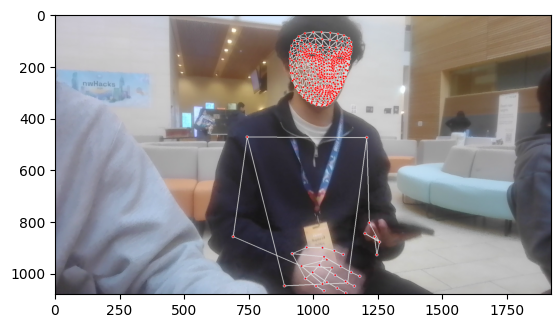

In [250]:
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

# 3. Extract Keypoint Values

In [251]:
len(results.left_hand_landmarks.landmark)

AttributeError: 'NoneType' object has no attribute 'landmark'

In [12]:
pose = []
for res in results.pose_landmarks.landmark:
    test = np.array([res.x, res.y, res.z, res.visibility])
    pose.append(test)

NameError: name 'results' is not defined

In [13]:
pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(132)
face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(1404)
lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)

NameError: name 'results' is not defined

In [14]:
if results.face_landmarks :
  face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten()
else :
  np.zeros(1404)


NameError: name 'results' is not defined

In [15]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

In [16]:
result_test = extract_keypoints(results)

NameError: name 'results' is not defined

In [17]:
result_test

NameError: name 'result_test' is not defined

In [18]:
468*3+33*4+21*3+21*3

1662

In [19]:
np.save('0', result_test)

NameError: name 'result_test' is not defined

In [255]:
np.load('0.npy')

array([ 0.59980208,  0.41611344, -0.37879068, ...,  0.65743577,
        0.80339921, -0.02155963])

# 4. Setup Folders for Collection

In [8]:
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('MP_Data')

# Actions that we try to detect
actions = np.array(['doomscrolling','nothing'])

# Thirty videos worth of data
no_sequences = 60

# Videos are going to be 30 frames in length
sequence_length = 150

In [9]:
for action in actions:
    for sequence in range(no_sequences):
        try:
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass

# 5. Collect Keypoint Values for Training and Testing

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
VIDEOS_PATH = "MP_Data"          # change if your folder name differs
max_videos_per_class = None     # set to an int for quick testing, e.g. 10

# Make sure MP_Data/<action>/<sequence>/ exists
for action in actions:
    action_path = os.path.join(DATA_PATH, action)
    os.makedirs(action_path, exist_ok=True)
    print(action) #fleming

def list_video_files(folder):
    exts = (".mp4", ".mov", ".m4v", ".avi", ".mkv")
    files = [f for f in os.listdir(folder) if f.lower().endswith(exts)]
    files.sort()
    return files

def save_video_as_keypoints(video_path, action, sequence_idx, holistic, sequence_length):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"[WARN] Could not open: {video_path}")
        return False

    # Make sequence folder
    seq_dir = os.path.join(DATA_PATH, action, str(sequence_idx))
    os.makedirs(seq_dir, exist_ok=True)

    keypoints_list = []

    # --- Read up to sequence_length frames (TRUNCATE if longer) ---
    while len(keypoints_list) < sequence_length:
        ret, frame = cap.read()
        if not ret:
            break  # video ended (too short)
        image, results = mediapipe_detection(frame, holistic)
        keypoints_list.append(extract_keypoints(results))

    cap.release()

    if len(keypoints_list) == 0:
        print(f"[WARN] No frames read from: {video_path}")
        return False

    # --- PAD with zeros if too short ---
    feature_dim = keypoints_list[0].shape[0]
    while len(keypoints_list) < sequence_length:
        keypoints_list.append(np.zeros(feature_dim, dtype=np.float32))

    # --- Save as .npy files (same as original notebook) ---
    for frame_num, keypoints in enumerate(keypoints_list[:sequence_length]):
        np.save(os.path.join(seq_dir, str(frame_num)), keypoints)

    return True

with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    for action in actions:
        action_video_dir = os.path.join(VIDEOS_PATH, action)
        if not os.path.isdir(action_video_dir):
            raise FileNotFoundError(f"Missing folder: {action_video_dir}")

        video_files = list_video_files(action_video_dir)
        if max_videos_per_class is not None:
            video_files = video_files[:max_videos_per_class]

        print(f"\nProcessing {len(video_files)} videos for class '{action}'...")

        for sequence_idx, vf in enumerate(video_files):
            video_path = os.path.join(action_video_dir, vf)
            ok = save_video_as_keypoints(video_path, action, sequence_idx, holistic, sequence_length)
            if ok:
                print(f"  ✓ {vf} -> MP_Data/{action}/{sequence_idx}/[0..{sequence_length-1}].npy")
            else:
                print(f"  ✗ {vf} skipped")



doomscrolling
nothing

Processing 60 videos for class 'doomscrolling'...
  ✓ 0.mp4 -> MP_Data/doomscrolling/0/[0..149].npy
  ✓ 1.mp4 -> MP_Data/doomscrolling/1/[0..149].npy
  ✓ 10.mp4 -> MP_Data/doomscrolling/2/[0..149].npy
  ✓ 11.mp4 -> MP_Data/doomscrolling/3/[0..149].npy
  ✓ 12.mp4 -> MP_Data/doomscrolling/4/[0..149].npy
  ✓ 13.mp4 -> MP_Data/doomscrolling/5/[0..149].npy
  ✓ 14.mp4 -> MP_Data/doomscrolling/6/[0..149].npy
  ✓ 15.mp4 -> MP_Data/doomscrolling/7/[0..149].npy
  ✓ 16.mp4 -> MP_Data/doomscrolling/8/[0..149].npy
  ✓ 17.mp4 -> MP_Data/doomscrolling/9/[0..149].npy
  ✓ 18.mp4 -> MP_Data/doomscrolling/10/[0..149].npy
  ✓ 19.mp4 -> MP_Data/doomscrolling/11/[0..149].npy
  ✓ 2.mp4 -> MP_Data/doomscrolling/12/[0..149].npy
  ✓ 20.MOV -> MP_Data/doomscrolling/13/[0..149].npy
  ✓ 21.MOV -> MP_Data/doomscrolling/14/[0..149].npy
  ✓ 22.MOV -> MP_Data/doomscrolling/15/[0..149].npy
  ✓ 23.MOV -> MP_Data/doomscrolling/16/[0..149].npy
  ✓ 24.MOV -> MP_Data/doomscrolling/17/[0..149].npy
  ✓ 

# 6. Preprocess Data and Create Labels and Features

In [188]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [189]:
label_map = {label:num for num, label in enumerate(actions)}
print(actions)

['doomscrolling' 'nothing']


In [190]:
label_map

{np.str_('doomscrolling'): 0, np.str_('nothing'): 1}

In [191]:
sequences, labels = [], []

for action in actions:
    action_path = os.path.join(DATA_PATH, action)

    # Get only numeric folders (0, 1, 2, ...)
    sequence_folders = sorted(
        [f for f in os.listdir(action_path) if f.isdigit()],
        key=int
    )

    for folder in sequence_folders:
        folder_path = os.path.join(action_path, folder)

        # Load all frame npys inside this folder
        frame_files = sorted(
            [f for f in os.listdir(folder_path) if f.endswith('.npy')],
            key=lambda x: int(x.split('.')[0])
        )

        # Safety check
        if len(frame_files) != sequence_length:
            continue

        window = []
        for frame_file in frame_files:
            res = np.load(os.path.join(folder_path, frame_file))
            window.append(res)

        sequences.append(window)
        labels.append(label_map[action])


In [192]:
np.array(sequences).shape

(60, 150, 1662)

In [193]:
np.array(labels).shape

(60,)

In [194]:
X = np.array(sequences)

In [195]:
X.shape

(60, 150, 1662)

In [196]:
y = to_categorical(labels).astype(int)

In [197]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

In [198]:
y

array([[1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1]])

In [199]:
y_test.shape

(3, 2)

In [200]:
# ========================================
# DATA VALIDATION - Run this to check for bad data/labels
# ========================================

print("=" * 60)
print("DATA VALIDATION REPORT")
print("=" * 60)

# 1. Check basic shape consistency
print("\n1. SHAPE VALIDATION")
print(f"   Total sequences: {len(sequences)}")
print(f"   Total labels: {len(labels)}")
print(f"   Expected feature dimension: 1662")
print(f"   Expected sequence length: {sequence_length}")

assert len(sequences) == len(labels), "ERROR: Mismatch between sequences and labels!"
print("   ✓ Sequences and labels count match")

# 2. Validate each sequence shape and data quality
print("\n2. SEQUENCE VALIDATION")
bad_sequences = []
for idx, seq in enumerate(sequences):
    seq_array = np.array(seq)

    # Check shape
    if seq_array.shape != (sequence_length, 1662):
        bad_sequences.append((idx, f"Bad shape: {seq_array.shape}"))
        continue

    # Check for NaN or Inf values
    if np.isnan(seq_array).any():
        bad_sequences.append((idx, "Contains NaN values"))
        continue

    if np.isinf(seq_array).any():
        bad_sequences.append((idx, "Contains Inf values"))
        continue

    # Check if all zeros (likely failed detection)
    if np.all(seq_array == 0):
        bad_sequences.append((idx, "All zeros - no detection"))
        continue

    # Check for unrealistic coordinate values (should be normalized 0-1 range mostly)
    if np.any(seq_array > 100) or np.any(seq_array < -100):
        bad_sequences.append((idx, f"Extreme values detected: min={seq_array.min():.2f}, max={seq_array.max():.2f}"))

if bad_sequences:
    print(f"   ✗ FOUND {len(bad_sequences)} BAD SEQUENCES:")
    for idx, reason in bad_sequences[:10]:  # Show first 10
        print(f"     - Sequence {idx}: {reason}")
    if len(bad_sequences) > 10:
        print(f"     ... and {len(bad_sequences) - 10} more")
else:
    print("   ✓ All sequences have valid shapes and values")

# 3. Label validation
print("\n3. LABEL VALIDATION")
unique_labels = np.unique(labels)
print(f"   Unique labels found: {unique_labels}")
print(f"   Expected labels: {list(label_map.values())}")

# Check label distribution
for action_name, label_idx in label_map.items():
    count = labels.count(label_idx)
    print(f"   - '{action_name}' (label {label_idx}): {count} samples")

# Check for invalid labels
valid_label_set = set(label_map.values())
invalid_labels = [l for l in labels if l not in valid_label_set]
if invalid_labels:
    print(f"   ✗ FOUND {len(invalid_labels)} INVALID LABELS: {set(invalid_labels)}")
else:
    print("   ✓ All labels are valid")

# 4. Class balance check
print("\n4. CLASS BALANCE")
label_counts = {label: labels.count(label) for label in unique_labels}
max_count = max(label_counts.values())
min_count = min(label_counts.values())
imbalance_ratio = max_count / min_count if min_count > 0 else float('inf')

print(f"   Max samples per class: {max_count}")
print(f"   Min samples per class: {min_count}")
print(f"   Imbalance ratio: {imbalance_ratio:.2f}x")

if imbalance_ratio > 3:
    print("   ⚠ WARNING: Significant class imbalance detected!")
    print("     Consider collecting more data for underrepresented classes")
else:
    print("   ✓ Classes are reasonably balanced")

# 5. Statistical checks on keypoint data
print("\n5. STATISTICAL VALIDATION")
all_data = np.array(sequences)
print(f"   Data shape: {all_data.shape}")
print(f"   Data type: {all_data.dtype}")
print(f"   Mean: {all_data.mean():.4f}")
print(f"   Std: {all_data.std():.4f}")
print(f"   Min: {all_data.min():.4f}")
print(f"   Max: {all_data.max():.4f}")

# Check for data leakage (duplicate sequences)
print("\n6. DUPLICATE DETECTION")
unique_seqs = []
duplicate_indices = []
for idx, seq in enumerate(sequences):
    seq_hash = hash(np.array(seq).tobytes())
    if seq_hash in unique_seqs:
        duplicate_indices.append(idx)
    else:
        unique_seqs.append(seq_hash)

if duplicate_indices:
    print(f"   ⚠ WARNING: Found {len(duplicate_indices)} potential duplicate sequences")
    print(f"     Indices: {duplicate_indices[:10]}")
else:
    print("   ✓ No duplicate sequences detected")

# 7. Per-class quality check
print("\n7. PER-CLASS QUALITY")
for action_name, label_idx in label_map.items():
    class_sequences = [sequences[i] for i, l in enumerate(labels) if l == label_idx]
    if class_sequences:
        class_data = np.array(class_sequences)
        zeros_ratio = (class_data == 0).sum() / class_data.size
        print(f"   {action_name}:")
        print(f"     - Samples: {len(class_sequences)}")
        print(f"     - Zero ratio: {zeros_ratio:.2%}")
        print(f"     - Mean: {class_data.mean():.4f}, Std: {class_data.std():.4f}")

        if zeros_ratio > 0.5:
            print(f"     ⚠ WARNING: High zero ratio - poor landmark detection!")

# Final summary
print("\n" + "=" * 60)
print("VALIDATION SUMMARY")
print("=" * 60)
critical_issues = len([b for b in bad_sequences if "NaN" in b[1] or "Inf" in b[1]])
warnings = len(bad_sequences) - critical_issues

if critical_issues > 0:
    print(f"✗ CRITICAL: {critical_issues} sequences with NaN/Inf values")
    print("  ACTION REQUIRED: Remove or fix these sequences before training!")
elif warnings > 0:
    print(f"⚠ WARNING: {warnings} sequences with quality issues")
    print("  RECOMMENDED: Review and consider removing these sequences")
else:
    print("✓ All validation checks passed!")
    print("  Data is ready for training")

print("=" * 60)

DATA VALIDATION REPORT

1. SHAPE VALIDATION
   Total sequences: 60
   Total labels: 60
   Expected feature dimension: 1662
   Expected sequence length: 150
   ✓ Sequences and labels count match

2. SEQUENCE VALIDATION
   ✓ All sequences have valid shapes and values

3. LABEL VALIDATION
   Unique labels found: [0 1]
   Expected labels: [0, 1]
   - 'doomscrolling' (label 0): 30 samples
   - 'nothing' (label 1): 30 samples
   ✓ All labels are valid

4. CLASS BALANCE
   Max samples per class: 30
   Min samples per class: 30
   Imbalance ratio: 1.00x
   ✓ Classes are reasonably balanced

5. STATISTICAL VALIDATION
   Data shape: (60, 150, 1662)
   Data type: float64
   Mean: 0.2946
   Std: 0.2957
   Min: -1.8037
   Max: 2.6008

6. DUPLICATE DETECTION
   ✓ No duplicate sequences detected

7. PER-CLASS QUALITY
   doomscrolling:
     - Samples: 30
     - Zero ratio: 3.48%
     - Mean: 0.2984, Std: 0.2946
   nothing:
     - Samples: 30
     - Zero ratio: 2.09%
     - Mean: 0.2908, Std: 0.2967

V

# 7. Build and Train LSTM Neural Network

In [201]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard

In [202]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [209]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='tanh', input_shape=(150,1662)))
model.add(LSTM(32, return_sequences=False, activation='tanh'))
model.add(Dense(16, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [210]:
res = [.7, 0.2, 0.1]

In [211]:
actions[np.argmax(res)]

np.str_('doomscrolling')

In [212]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [213]:
model.fit(X_train, y_train, epochs=50, callbacks=[tb_callback])

Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 551ms/step - categorical_accuracy: 0.4603 - loss: 0.7337
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 513ms/step - categorical_accuracy: 0.4044 - loss: 0.6949
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 515ms/step - categorical_accuracy: 0.4850 - loss: 0.6922
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 298ms/step - categorical_accuracy: 0.4850 - loss: 0.6903
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 310ms/step - categorical_accuracy: 0.4954 - loss: 0.6888
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 286ms/step - categorical_accuracy: 0.5267 - loss: 0.6861
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 317ms/step - categorical_accuracy: 0.5475 - loss: 0.6838
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 299ms/step - categorical_accuracy: 0.5864 - loss: 0.6810
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 294ms/step - categorical_accuracy: 0.7997 - loss: 0.6801
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 308ms/step - categorical_accuracy: 0.7842 - loss: 0.6720
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s

In [214]:
model.summary()

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_42 (LSTM)                  │ (None, 150, 64)        │       442,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_43 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 2)              │            34 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,365,272 (5.21 MB)

 Trainable params: 455,090 (1.74 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 910,182 (3.47 MB)

# 8. Make Predictions

In [183]:
res = model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step


In [184]:
actions[np.argmax(res[1])]

np.str_('nothing')

In [185]:
actions[np.argmax(y_test[0])]

np.str_('doomscrolling')

# 9. Save Weights

In [218]:
from tensorflow.keras.models import load_model

In [219]:
model.save('action.h5')

In [220]:
model = load_model('action.h5')

# 10. Evaluation using Confusion Matrix and Accuracy

In [373]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [374]:
yhat = model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


In [375]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [376]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[1, 0],
        [0, 1]],

       [[1, 0],
        [0, 1]]])

In [377]:
accuracy_score(ytrue, yhat)

1.0

# Task
Delete folders `MP_Data/doomscrolling/0` through `MP_Data/doomscrolling/29` (inclusive), along with their contents.

## Delete Specific Doomscrolling Folders

### Subtask:
Delete folders `MP_Data/doomscrolling/0` through `MP_Data/doomscrolling/29` (inclusive), along with their contents.


**Reasoning**:
To delete directories and their contents as specified in the instructions, I need to import the `shutil` module, iterate through the specified range, construct the folder paths, and use `shutil.rmtree` within a try-except block.



In [160]:
import shutil
import os

# Define the base path for the data
DATA_PATH = 'MP_Data'
ACTION = 'doomscrolling'

# Loop through folders 0 to 29 (inclusive)
for i in range(30):
    folder_to_delete = os.path.join(DATA_PATH, ACTION, str(i))
    try:
        shutil.rmtree(folder_to_delete)
        print(f"Successfully deleted: {folder_to_delete}")
    except FileNotFoundError:
        print(f"Folder not found, skipping: {folder_to_delete}")
    except Exception as e:
        print(f"Error deleting {folder_to_delete}: {e}")

print("Deletion process finished for specified doomscrolling folders.")

Successfully deleted: MP_Data/doomscrolling/0
Successfully deleted: MP_Data/doomscrolling/1
Successfully deleted: MP_Data/doomscrolling/2
Successfully deleted: MP_Data/doomscrolling/3
Successfully deleted: MP_Data/doomscrolling/4
Successfully deleted: MP_Data/doomscrolling/5
Successfully deleted: MP_Data/doomscrolling/6
Successfully deleted: MP_Data/doomscrolling/7
Successfully deleted: MP_Data/doomscrolling/8
Successfully deleted: MP_Data/doomscrolling/9
Successfully deleted: MP_Data/doomscrolling/10
Successfully deleted: MP_Data/doomscrolling/11
Successfully deleted: MP_Data/doomscrolling/12
Successfully deleted: MP_Data/doomscrolling/13
Successfully deleted: MP_Data/doomscrolling/14
Successfully deleted: MP_Data/doomscrolling/15
Successfully deleted: MP_Data/doomscrolling/16
Successfully deleted: MP_Data/doomscrolling/17
Successfully deleted: MP_Data/doomscrolling/18
Successfully deleted: MP_Data/doomscrolling/19
Successfully deleted: MP_Data/doomscrolling/20
Successfully deleted: M

## Final Task

### Subtask:
Confirm the deletion of the specified folders within `MP_Data/doomscrolling` and ensure the notebook is ready for the next steps.


## Summary:

### Data Analysis Key Findings
*   The Python script successfully deleted all specified folders, specifically `MP_Data/doomscrolling/0` through `MP_Data/doomscrolling/29`, inclusive.
*   All target folders existed before deletion, as no `FileNotFoundError` exceptions were reported during the process.

### Insights or Next Steps
*   The `MP_Data/doomscrolling` directory is now clean and prepared for subsequent data generation or analysis without interference from previous iterations.
*   It is recommended to visually confirm the absence of these folders in the file system to ensure complete data hygiene before proceeding with further steps.
